In [19]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from pathlib import Path
from progiter import ProgIter
from IPython import display

import torch
import pandas as pd
import numpy as np


from src.prev.data_loading import get_values, Kind, Split
from src.prev.calibration import calibrate_logits_fast, missmatch_priors
from src.prev.scaling import  scale_prevalences_ir
from src.prev.plotting import plot_aggregate_results, Confidence, box_plot, multiplot
from src.prev.utils import Metric, compute_all_metrics, last_value_df
from src.prev.calibration import CalibrationMethod

current_path = os.getcwd()
DATA_PATH = Path(current_path).parent/ 'data'
RESULT_PATH = Path(current_path).parent/ 'results'
assert DATA_PATH.exists() and RESULT_PATH.exists()
torch.manual_seed(seed=0)

In [2]:
all_tasks = ['lapgyn4_surgical_actions', 'lapgyn4_instrument_count', 'lapgyn4_anatomical_actions', 'nerthus_bowel_cleansing_quality', 'hyperkvasir_therapeutic-interventions', 'cholec80_grasper_presence', 'cholec80_hook_presence', 'idle_action_recognition', 'brain_tumor_classification', 'brain_tumor_type_classification', 'chexpert_enlarged_cardiomediastinum', 'chexpert_cardiomegaly', 'chexpert_edema', 'chexpert_consolidation', 'chexpert_pneumonia', 'chexpert_pneumothorax', 'chexpert_pleural_effusion', 'chexpert_fracture', 'pneumonia_classification', 'covid_xray_classification', 'deep_drid_dr_level', 'deep_drid_quality', 'kvasir_capsule_anatomy', 'mura_xr_wrist', 'mura_xr_shoulder', 'mura_xr_humerus', 'mura_xr_hand', 'mura_xr_forearm', 'mura_xr_finger', 'mura_xr_elbow']
binary_tasks = ['hyperkvasir_therapeutic-interventions', 'cholec80_grasper_presence', 'cholec80_hook_presence', 'idle_action_recognition', 'brain_tumor_classification', 'chexpert_enlarged_cardiomediastinum', 'chexpert_cardiomegaly', 'chexpert_edema', 'chexpert_consolidation', 'chexpert_pneumonia', 'chexpert_pneumothorax', 'chexpert_pleural_effusion', 'chexpert_fracture', 'pneumonia_classification', 'covid_xray_classification', 'deep_drid_quality', 'kvasir_capsule_anatomy', 'mura_xr_wrist', 'mura_xr_shoulder', 'mura_xr_humerus', 'mura_xr_hand', 'mura_xr_forearm', 'mura_xr_finger', 'mura_xr_elbow']
data = {}
for t in ProgIter(all_tasks, desc='Loading data'):
    data[t] = get_values(t, DATA_PATH, proj='mic23_predictions_original_0')  # original paper predictions
    # data[t] = get_values(t, DATA_PATH, proj='mic23_predictions_reproduce_0')  # additional seed experiment

Loading data 100.00% 30/30... rate=4.26 Hz, eta=0:00:00, total=0:00:07


In [3]:
def metrics_across_ir(task_data, step=0.5, calibration: CalibrationMethod = CalibrationMethod.NONE, std=None):
    """ 
    Computes metrics values accross imbalance ratios for a given task.

    :param task_data:
    :param step: step size for varying the imbalance ratio
    :param calibration:
    :param std: used for estimating prevalence for scaling and metric computation, defaults to 2 None

    """
    # initialize results dictionary
    results ={m: [] for m in Metric}
    results.update(zip(["reference "+m.value for m in Metric], [[] for m in Metric]))
    # define the imbalance ratio range
    ir_range = np.arange(1, 10+step, step)
    #iterate over the imbalance ratio range
    for ir in ir_range:
        # scale prevalences in the deployment set according to imbalance ratio
        app_test_logits, app_test_classes = scale_prevalences_ir(logits=task_data[Kind.LOGITS][Split.APP_TEST],
                                                                         classes=task_data[Kind.LABELS][Split.APP_TEST],
                                                                         ir=ir)
        # create a data dictionary with the modified deployment test set
        mod_data = {Kind.LOGITS: {Split.DEV_CAL: task_data[Kind.LOGITS][Split.DEV_CAL],
                                      Split.DEV_TEST: task_data[Kind.LOGITS][Split.DEV_TEST],
                                      Split.APP_TEST: app_test_logits},
                        Kind.LABELS: {Split.DEV_CAL: task_data[Kind.LABELS][Split.DEV_CAL],
                                      Split.DEV_TEST: task_data[Kind.LABELS][Split.DEV_TEST],
                                      Split.APP_TEST: app_test_classes}}
        if calibration==CalibrationMethod.AFFINE_REWEIGHTED:
            # define exact prior to use if calibrating using real priors
            prior = torch.bincount(mod_data[Kind.LABELS][Split.APP_TEST]) / len(mod_data[Kind.LABELS][Split.APP_TEST])
        else:
            prior = None
        if calibration==CalibrationMethod.AFFINE_ESTIMATED:
            # calibrate logits using estimated prevalences
            estimated_prevalence, calibrated_logits = calibrate_logits_fast(data = mod_data,
                                                                       calibration=calibration, 
                                                                       prior = prior, 
                                                                       return_estimate=True, std=std)
        else:
            # calibrate logits and get estimated prevalence
            calibrated_logits = calibrate_logits_fast(data = mod_data, calibration=calibration, prior = prior,
                                                 return_estimate=False)
            real_prior = torch.bincount(mod_data[Kind.LABELS][Split.APP_TEST]) / mod_data[Kind.LABELS][Split.APP_TEST].size(0)
            estimated_prevalence = missmatch_priors(priors=real_prior, std=std)

        # compute number of samples in each class of the dev cal set
        val_prevalences = torch.bincount(mod_data[Kind.LABELS][Split.DEV_CAL])
        # define minimal and maximal class in the dev cal set
        min_class = torch.argmin(val_prevalences)
        max_class = torch.argmax(val_prevalences)
        # catches case where for balanced task, min class was used as max class in scaling
        if min_class==max_class:
            min_class=1
        # compute predictions on scaled deployment set and development test set according to argmax decision rule
        new_app_test_preds = torch.argmax(calibrated_logits[Split.APP_TEST], dim=1)
        dev_test_preds = torch.argmax(calibrated_logits[Split.DEV_TEST], dim=1)

        #compute the exact prevalence in the scaled deployment set
        exact_prevalence = torch.bincount(mod_data[Kind.LABELS][Split.APP_TEST])/len(mod_data[Kind.LABELS][Split.APP_TEST])

        #compute the metrics on the deployment and development sets
        dep_metrics = compute_all_metrics(mod_data[Kind.LABELS][Split.APP_TEST], calibrated_logits[Split.APP_TEST], new_app_test_preds,
                                          min_class=min_class, exact_priors=exact_prevalence, estimated_priors=exact_prevalence)
        dev_metrics = compute_all_metrics(mod_data[Kind.LABELS][Split.DEV_TEST], calibrated_logits[Split.DEV_TEST], dev_test_preds,
                                          min_class=min_class, exact_priors=exact_prevalence, estimated_priors=estimated_prevalence)
        # append metrics to the results dictionary
        for k in dep_metrics.keys():
            results[k].append(dep_metrics[k])
        for k in dev_metrics.keys():
            results['reference '+k.value].append(dev_metrics[k])
    return results


In [4]:
# compute metrics at different IRs for different calibration methods and estimated priors
# iterate over calibration methods
for cal in [CalibrationMethod.NONE, CalibrationMethod.AFFINE_REWEIGHTED, CalibrationMethod.AFFINE_ESTIMATED]:
    # iterate over stds for non-exact priors
    for std in [0.05, 0.075, 0.1]:
        # iterate over tasks
        for t in ProgIter(all_tasks):
            # compute metrics for the task at different imbalance ratios
            data[t].update(metrics_across_ir(task_data=data[t],
                                calibration=cal, std=std))
        # save results to a dataframe
        result_df = pd.DataFrame(all_tasks, columns=["name"])
        for key in data[all_tasks[0]].keys():
            if key not in ["name", Kind.LABELS, Kind.LOGITS]:
                result_df[key] = [torch.tensor(data[t][key]) for t in all_tasks]
            else:
                result_df[key] = [data[t][key] for t in all_tasks]
        result_df.to_pickle(RESULT_PATH / ("exp_3_results_"+cal.value+f"_std_{std}.pkl"))

 0.00%  0/30... rate=0 Hz, eta=?, total=0:00:00

 100.00% 30/30... rate=2.38 Hz, eta=0:00:00, total=0:00:12
 100.00% 30/30... rate=2.38 Hz, eta=0:00:00, total=0:00:12
 100.00% 30/30... rate=2.35 Hz, eta=0:00:00, total=0:00:12
 100.00% 30/30... rate=1.83 Hz, eta=0:00:00, total=0:00:16
 100.00% 30/30... rate=1.85 Hz, eta=0:00:00, total=0:00:16
 100.00% 30/30... rate=1.86 Hz, eta=0:00:00, total=0:00:16
 100.00% 30/30... rate=1.95 Hz, eta=0:00:00, total=0:00:15
 100.00% 30/30... rate=1.90 Hz, eta=0:00:00, total=0:00:15
 100.00% 30/30... rate=1.90 Hz, eta=0:00:00, total=0:00:15


## Generating Figure 5

In [5]:
#initialize the list of subplots
subplts = []

# iterate over calibration methods
for cal in [CalibrationMethod.NONE, CalibrationMethod.AFFINE_REWEIGHTED]:#, CalibrationMethod.AFFINE_ESTIMATED]):
    # define relevant metrics based on the calibration method used
    if (cal == CalibrationMethod.NONE)|(cal==CalibrationMethod.AFFINE_REWEIGHTED):
        metrics = [Metric.ACCURACY, Metric.F1, Metric.MCC, Metric.EC_ADJUSTED]
    elif cal==CalibrationMethod.AFFINE_ESTIMATED:
        metrics = [Metric.ACCURACY, Metric.F1, Metric.MCC, Metric.EC_EST]
    else:
        raise ValueError(f'{cal=}')

    # load relevant results file ommiting the small task
    name = "exp_3_results_"+cal.value+"_std_0.05.pkl"    
    result_df = pd.read_pickle(RESULT_PATH / name)
    
    #compute value of metrics at imbalance ratio 10
    ir_10_metrics = last_value_df(result_df, metrics=metrics)
    # create subplot
    subplt = plot_aggregate_results(result_df, metrics=metrics, file=RESULT_PATH / f"{cal.value}.svg",
                                    delta=False, ci=Confidence.STD, y_axis_title="Absolute difference to metric score on $D_{app}$ set", title= None, opacity=0.15, line_width=4, bound=[0, 0.3])
    # append subplot to subplots list
    subplts.append(subplt)
    # create sub box plot
    subplt = box_plot(ir_10_metrics, metrics)
    # save box plot
    subplt.write_image(RESULT_PATH / f"{cal.value}_box.svg")
    # append sub box plot to subplots list
    subplts.append(subplt)


In [6]:
# define y axis ranges for subplots
sub_y_ranges =  {0: [0, 0.3], 1: [-0.02, 0.48], 2: [0, 0.3], 3: [-0.02, 0.48]}
# create Fig 5. from the paper
fig = multiplot(rows=2, cols=2, row_titles=["w/o re-calibration", "with re-calibration"],y_title  = "Absolute difference to metric score on D<sub>test</sub> set",
 subplts=subplts, horizontal_spacing = 0.03, vertical_spacing=0.03, legend_index=1, 
 sub_x_axis_titles={2: "Imbalance ratio"}, sub_y_ranges=sub_y_ranges, height=800, shared_yaxes=False)
# change the display name from "EC dep prev" to "EC"
fig['data'][11]['name'] = "EC"
fig['data'][23]['name'] = "EC"
fig

In [7]:
# save figures
fig.write_image(RESULT_PATH / f"fig_5.png")
fig.write_image(RESULT_PATH / f"fig_5.pdf")
fig.write_html(RESULT_PATH / f"fig_5.html")

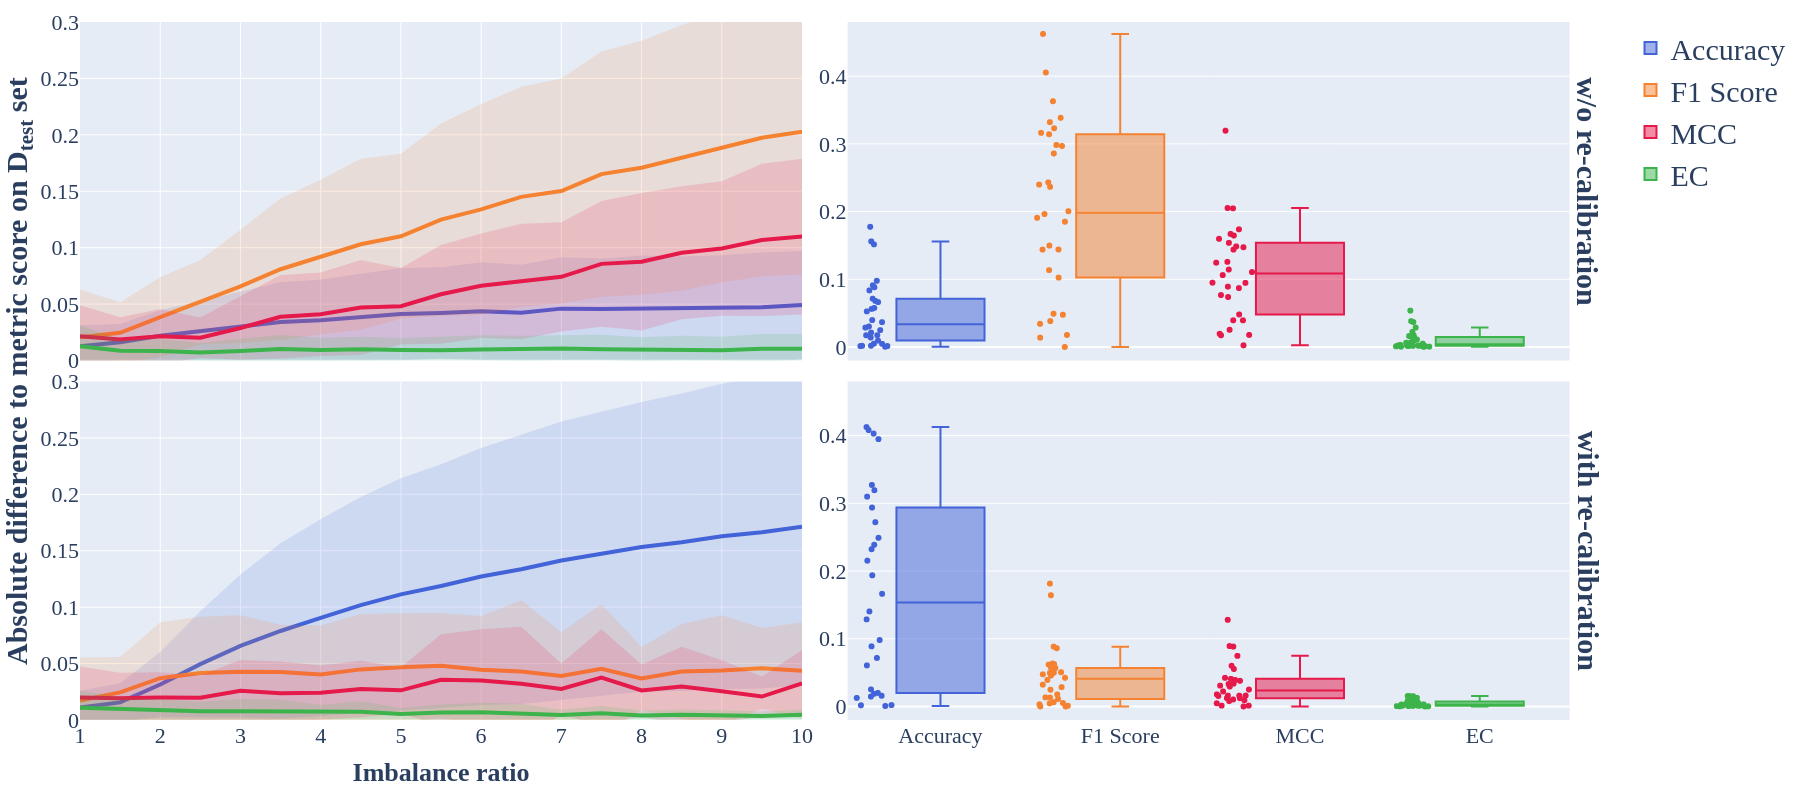

In [20]:
display.Image(RESULT_PATH / f"fig_5.png")

## Supplement plot

In [8]:
# initialize supplement dataframe 
sup_df = pd.DataFrame(all_tasks, columns=['name'])
# define calibration method
cal = CalibrationMethod.NONE
# iterate over standard deviations for non-exact priors
for std in [0.05, 0.075, 0.1]:
    # load relevant result file
    result_df = pd.read_pickle(RESULT_PATH / ("exp_3_results_" + str(cal.value) + f"_std_{std}.pkl"))
    # compute differences in metrics' values
    sup_df[f"EC (est. prev.) std={std}"] = result_df[Metric.EC_EST] - result_df['reference ' + str(Metric.EC_EST.value)]
    sup_df[Metric.ACCURACY.value] = result_df[Metric.ACCURACY] - result_df['reference Accuracy']
    sup_df[Metric.BALANCED_ACC.value] = result_df[Metric.BALANCED_ACC] - result_df['reference Bal. Accuracy']
    sup_df[Metric.AUROC.value] = result_df[Metric.AUROC] - result_df['reference AUROC']
    sup_df[Metric.EC_ADJUSTED.value] = result_df[Metric.EC_ADJUSTED] - result_df['reference '+ str(Metric.EC_ADJUSTED.value)]

In [9]:
# define the metrics list
metrics = [k for k in sup_df.keys() if k!="name"]

In [10]:
# plot the subplots
fig1 = plot_aggregate_results(sup_df, metrics=[Metric.ACCURACY, Metric.BALANCED_ACC,Metric.AUROC, Metric.EC_ADJUSTED], y_axis_title="Absolute difference to <br>metric score on D<sub>test</sub> set", ci=Confidence.NONE)
fig2 = plot_aggregate_results(sup_df, metrics =['EC (est. prev.) std=0.05', 'EC (est. prev.) std=0.075', 'EC (est. prev.) std=0.1'], ci=Confidence.NONE)

In [11]:
# aggragate in 1 figure
for i, value in enumerate(fig2['data']):
    value['showlegend']=True
    fig1.add_trace(value)

In [12]:
# compute values at imbalance ratio 10
ir_10_metrics = last_value_df(sup_df, metrics=metrics, delta=False)

In [13]:
# create box plots
box1 = box_plot(ir_10_metrics, metrics=[Metric.ACCURACY, Metric.BALANCED_ACC,Metric.AUROC, Metric.EC_ADJUSTED])
box2 = box_plot(ir_10_metrics, metrics =['EC (est. prev.) std=0.05', 'EC (est. prev.) std=0.075', 'EC (est. prev.) std=0.1'])
# aggregate box plots in 1 figure
for  value in box2['data']:
    value['showlegend']=True
    box1.add_trace(value)

In [14]:
# create Fig. 9 from supplement
fig = multiplot(rows=1, cols=2, subplts=[fig1, box1], horizontal_spacing=0.04, legend_index=1, 
sub_y_axis_titles={0:"Absolute difference to <br> metric score on D<sub>test</sub> set"}, sub_x_axis_titles={0: "Imbalance ratio"}, sub_y_ranges={0: [0, 0.05]}, shared_yaxes=False)

In [16]:
# save figures
name = "fig_9"
fig.write_image(RESULT_PATH / f"{name}.png")
fig.write_image(RESULT_PATH / f"{name}.pdf")
fig.write_html(RESULT_PATH / f"{name}.html")

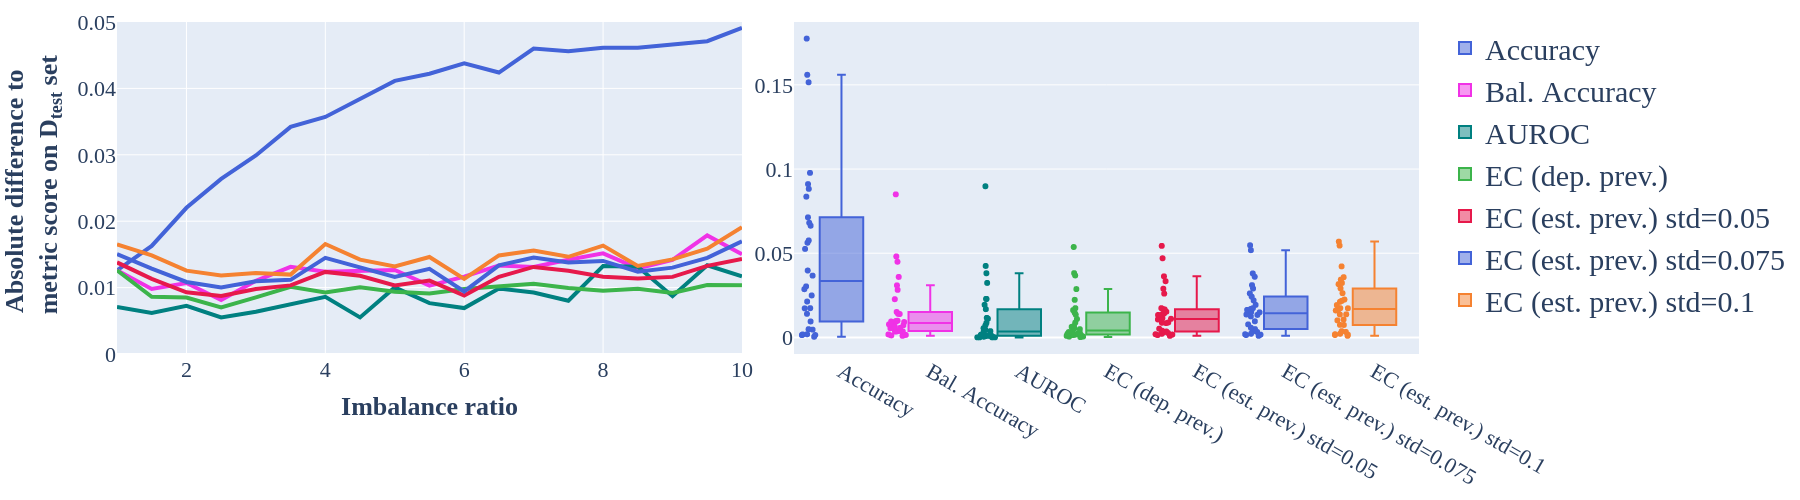

In [22]:
display.Image(RESULT_PATH / f"fig_9.png")